Import neccessary packages

In [40]:
import numpy as np
# import pickle
import cv2
import matplotlib.pyplot as plt

In [41]:
directory_root = '../input/plantvillage/'

Function to convert images to array

In [42]:
from keras.preprocessing.image import img_to_array

In [70]:
def convert_image_to_array(image_dir):
    image = cv2.imread(image_dir)
    if image is not None :
        image = cv2.resize(image,(256, 256))   
        return img_to_array(image)
    else :
        return np.array([])

Fetch images from directory

In [44]:
from os import listdir

In [46]:
# Initialize empty lists to store image arrays and their corresponding labels
image_list, label_list = [], []

# List all directories in the directory_root
root_dir = listdir(directory_root)

# Remove .DS_Store files from the root directory list
for directory in root_dir :
    if directory == ".DS_Store" :
        root_dir.remove(directory)

# Loop through plant folders in the root directory
for plant_folder in root_dir :
    
    # List all subdirectories (disease folders) in the current plant folder
    plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
    
    # Remove .DS_Store files from the disease folder list
    for disease_folder in plant_disease_folder_list :
        if disease_folder == ".DS_Store" :
            plant_disease_folder_list.remove(disease_folder)
    
    # Loop through the cleaned list of plant disease folders
    for plant_disease_folder in plant_disease_folder_list:
        
        # List all the images in the current plant disease folder
        plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
        # Remove .DS_Store files from the image list    
        for single_plant_disease_image in plant_disease_image_list :
            if single_plant_disease_image == ".DS_Store" :
                plant_disease_image_list.remove(single_plant_disease_image)
        
        # Loop through the first 200 images (if available) in the cleaned image list
        for image in plant_disease_image_list[:200]:
            
            # Construct the image directory path
            image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
            
            # Check if the image file has a .jpg or .JPG extension
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                
                # Convert the image to an array and append it to the image_list
                image_list.append(convert_image_to_array(image_directory))
                
                # Append the plant disease folder's name (label) to the label_list
                label_list.append(plant_disease_folder)


[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Image loading completed


Get Size of Processed Image

In [47]:
image_size = len(image_list)
image_size

2952

### Transform labels to numbers 

In [48]:
from sklearn.preprocessing import LabelBinarizer

In [50]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
# pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
n_classes

15

### Classes names

In [51]:
for i in label_binarizer.classes_:
    print(i)

Pepper__bell___Bacterial_spot
Pepper__bell___healthy
Potato___Early_blight
Potato___Late_blight
Potato___healthy
Tomato_Bacterial_spot
Tomato_Early_blight
Tomato_Late_blight
Tomato_Leaf_Mold
Tomato_Septoria_leaf_spot
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato__Target_Spot
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato__Tomato_mosaic_virus
Tomato_healthy


### Normalizing data

In [54]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
print("[INFO] Spliting data to train, test")
x_train, x_test, \
y_train, y_test = train_test_split(np_image_list, \
                                   image_labels, \
                                   test_size=0.2, \
                                   random_state = 42
                                  ) 

[INFO] Spliting data to train, test


In [57]:
from keras.preprocessing.image import ImageDataGenerator

In [58]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [59]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K

In [65]:
EPOCHS = 5

model = Sequential()
chanDim = -1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256, 256, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024))
model.add(Activation("relu"))

model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
activation_43 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_44 (Activation)   (None, 85, 85, 64)        0         
__________

In [67]:
from keras.optimizers import Adam

In [68]:
opt = Adam(lr=0.001, decay=0.001 / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] training network...


In [69]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/5
73/73 [==============================] - 854s 12s/step - loss: 0.2207 - acc: 0.9319 - val_loss: 0.7834 - val_acc: 0.8936
Epoch 2/5
73/73 [==============================] - 848s 12s/step - loss: 0.1662 - acc: 0.9458 - val_loss: 0.6594 - val_acc: 0.9119
Epoch 3/5
73/73 [==============================] - 840s 12s/step - loss: 0.1321 - acc: 0.9539 - val_loss: 0.1861 - val_acc: 0.9472
Epoch 4/5
73/73 [==============================] - 841s 12s/step - loss: 0.1127 - acc: 0.9606 - val_loss: 0.1752 - val_acc: 0.9521
Epoch 5/5
73/73 [==============================] - 838s 11s/step - loss: 0.1164 - acc: 0.9584 - val_loss: 0.5217 - val_acc: 0.9148


In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=1, verbose=1
    )

Plot the train and val curve

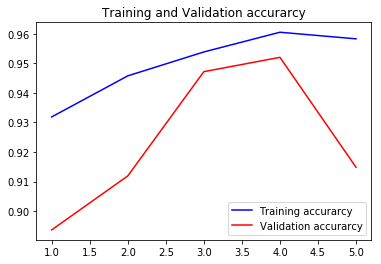

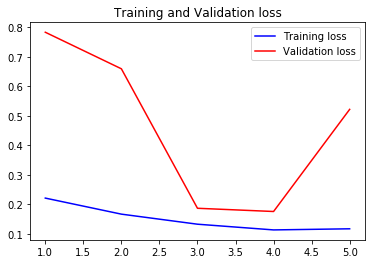

In [71]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [72]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
591/591 [==============================] - 50s 85ms/step
Test Accuracy: 91.48336180979022


In [73]:
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

In [31]:
model.save('plant_disease.h5')